# Simulation of photoelectrochemical currents with recombination in the space charge layer
$$\require{mhchem}$$
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

Adapts analyses in 
>Reichman, J., The current voltage Characteristics of semiconductor-electrolyte junction photovoltaic cells  [*Appl. Phys. Lett.* **1980**, 36, 574-577](http://aip.scitation.org/doi/10.1063/1.91551).  

See also:
>Gärtner, W. W. Depletion-Layer Photoeffects in Semiconductors. [*Phys. Rev.* **1959**, 116, 84–87](https://link.aps.org/doi/10.1103/PhysRev.116.84).

The comparison of this approach to a full Poisson drift-diffusion solution done in AFORS-HET is discussed in the following book chapeter  
>Ager, J. W. Chapter 6. Approaches for Stable and Efficient Photoelectrodes. In Integrated Solar Fuel Generators; Sharp, I. D., Atwater, H. A., Lewerenz, H.-J. L., Eds.; [Royal Society of Chemistry, **2018**; pp 183–213](http://ebook.rsc.org/?DOI=10.1039/9781788010313-00183).

Reichman extends the approach of Gärtner but has space charge layer (SCR) recombination, and both electron and hole currents. The example given in the paper is an n-type semiconductor but the approach could be used equally as well for the p-type case. 

In contrast to later studies: 
>[Kelly and Memming **1982**](https://iopscience.iop.org/article/10.1149/1.2123961/meta)    
>[Li and Peter **1985**](https://www.sciencedirect.com/science/article/abs/pii/0022072885850506)   
> [Khan and Bockris **1984**](https://pubs.acs.org/doi/abs/10.1021/j150656a016)     

surface states are not included. Also, the rate constants for electron and hole transfer to the electrolyte do not depend on the potential such the rates depend only on the population of the electrons and holes at the surface. 

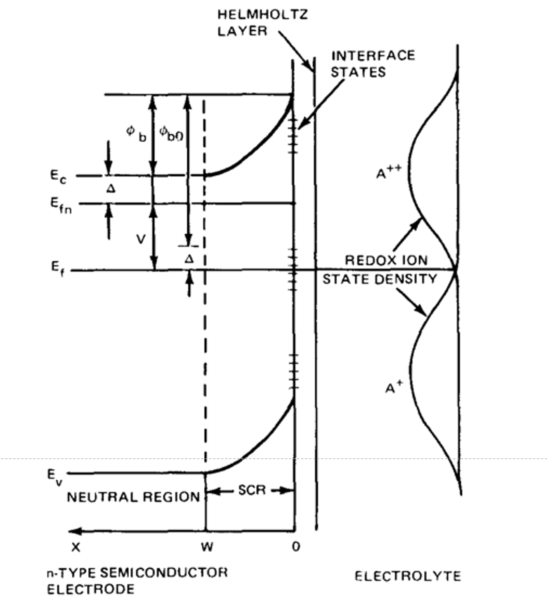

Depicted here is the situation with a voltage $V$ applied to an n-type semiconductor. The electron concentration in the bulk can be calculated from the difference $\Delta$ between the bulk Fermi level and the conduction band minimum (and the CB DOS).

The Fermi level for electrons $E_{fn}$ is displaced by applied voltage $V$ from the value it would have at equilibrium ($E_F$) with equal Fermi levels in the semiconductor and in the electrolyte. To align the Fermi levels at the semiconductor-electrolyte interface at equilibrium, the electron concentration near the surface is depleted, bending the bands up by an amount $\phi_{b0}$. This creates a positively charge space charge layer (SCR) as the electrons have been removed but the positively charged donor site remain in place. The width of the SCR is a function of actual band bending with the potential applied, $\phi_b$. $\phi_b$ is decreased as the potential $V$ is applied to reduce the band bending (this would be a negative potential in this case). When the applied voltage is equal to $\phi_{b0}$ the semiconductor is in the flat band condition with a SCR width of zero. 

Because recombination requires both electrons and holes, its rate is reduced in the SCR. In fact, some analyses had assumed that it was zero. The analysis of Reichmann was the first, to my knowledge, model the effects of recombination the SCR, which is done by specifying a minority carrier lifetime parameter $\tau$. Further, Reichman considers the effect of the kinetics of electron and hole transfer on the recombination rate which he does by specifying the exchange current density at equilibrim $I_{0n}$ and $I_{0p}$ for each carrier type. Intuitively, one would expect that if hole transfer to the solution were slow, holes would build up in the SCR and be more likely to recombine. This is in fact predicted by Reichman's analysis. 

**Comments on figure**  
1. The sketch indicates $V \approx 0.3$ V compared to the equilibrium band banding of 0.7 V.
2. The Fermi level in the solution is shown for equilbrium. Under bias, it should follow that of the majority carriers, electrons in this case, so that a potential drop across the double layer does not develop. So it should be displaced upward (or equivalently, the semiconductor should be pulled down. This is an the essential difference between semiconductors and metals in contact with an electrolyte. Another way to say this is that $V$ acts only to change the potential *inside the semiconductor*; current across the interface is affected by the changes in surface electron/hole concentrations only. 

The analysis begins with the following expressions for electron and hole currents at the semiconductor/elecrolyte interface (SEI):

$$J_n = -I^0_n (n_s/n_{s0}-1)  \tag{1}$$
$$J_p = I^0_p (p_s/p_{s0}-1)  \tag{2} $$

$I^0_n$ and $I^0_p$ reflect the kinetics of electron and hole transfer to the solution and will be important later. Note that at equibrium both currents are zero (not equal and opposite). I think this analysis is similar to the method used to compute surface recombination velocities. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Python script with SI units, cgs conversions, and physical constants
from units import *

In [2]:
# Parameters used throughout simulations
T = 300*kelvin

ns = 1e-9 * sec
ps = 1e-12 * sec

μA = 1e-6 * amp
nA = 1e-9 * amp
pA = 1e-12 * amp

# Materials, Surface, and Illumination classes

It is convenient to use python classes to describe the material, surface, and illumination conditions to simplify changing these parameters to compare different cases. 

## Materials

In [3]:
class Material():
    """Materials properties, defaults are GaAs-like from Reichman paper"""
    # Instrinsic properties
    ni = 1e7*cm**-3 
    ϵ = 12
    # Extrinsic properties
    ND = 1e16*cm**-3    # Assume n-type at this point
    L = 0.5e-4*cm  
    τ = 1e-9*sec

## Surfaces

In [4]:
class Surface(): 
    """Surface conditions, defaults are Reichman base case"""
    # Flat band potential
    ϕb0 = 0.7*volt
    # Rate constants for electron and hole transfer to electrolyte
    I0n = 1e-10*mA*cm**-2
    I0p = 1e-5*mA*cm**-2

## Illumination

In [5]:
class Illumination(): 
    """Illumination, defaults are Reichman base case"""
    α = 3e4*cm**-1      # Implies a wavelength choice
    I0 = 1*mA*cm**-2    # Light intensity expressed as current density

## Reichman base case

In Reichman's paper, parameters similar to that of n-GaAs were used. 

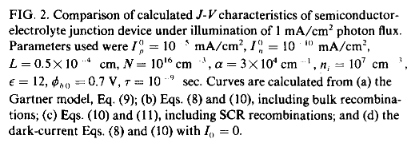

In [6]:
GaAs = Material()
base_surface = Surface()
base_illumination = Illumination()

# Make a tuple which can be expanded later as *base_case
base_case = (GaAs, base_surface, base_illumination)

# Gärtner model  
Carriers in SCR and within one minority carrier diffusion length of the edge of the SCR make it to the surface and contribute to photocurrent. At the equilibrium potential, the photocurrent will be due to carriers generated in both the SCR and (within one diffusion length of the boundary) the neutral region. The photocurrent will decrease with potential as the width of the SCR decreases.  

In the depletion approximation the width of the SCR $W$ is:

$$W = \left( \frac{2 \epsilon \epsilon_0 (\phi_{b0}-V)}{q N_D} \right)^{1/2}$$

where $\epsilon$ is the dielectric constant and $N_D$ is the donor density. The bulk hole concentration $p_0$ is

$$p_0 = \frac{n_i^2}{N_D} $$

where $n_i$ is the intrinsic carrier concentration and full ionization of the donors has been assumed. 

Solving for the hole current at the bulk/SCR interface.  
Diffusion-drift equation for holes with photogeneration and recombination terms in the neutral region is:

$$D \frac{d^2p}{dx^2} - \frac{p-p_0}{\tau} + I_0 \alpha \exp(-\alpha x) = 0 $$

noting that there is no drift term as there is no field there. The BCs are $p = p_0$ at $x = \infty$ and $p = p_W$ at $x = W$

The hole current at the boundary $J_W$ will be (at this point $p_W$ is not determined yet):

$$J_W = -Jo(p_W/p_0-1) + qI_0\alpha L \frac{\exp(-\alpha W)}{1+\alpha L} \tag{4}$$

with saturation current $J_0$

$$J_0 = \frac{q p_0 L}{\tau}$$

(Looks like this is a balance between the total generation in the SCR and within L of it and holes diffusing away, in the region where they are perturbed from their equilibirum concentration)

Now, Reichman works to relate the electron and hole concentrations at the surface with those at the SCR/neutral interface. 


$$ n_s = n_W \gamma_1 \exp(-q \phi_b/kT)  \tag{5}$$
$$ p_s = p_W \gamma_2 \exp(+q \phi_b/kT) \tag{6}$$

$\gamma_1$ and $\gamma_2$ take into account that the surface might have a different DOS than the bulk due to the presence of surface states as shown in the sketch above (note that he will not distinguish between electrons and holes in surface states compared to those at the band edges in the kinetic equations which follow.. He does point out, though, that mid-gaps states should be treated separately as recombination sites). 

If one neglects recombination at the SCR and at the surface (interface with the electrolyte) then the current density at the surface, going into the electrolyte, will be the sum of the current at the neutral/SCR boundary (see above) and the current from the SCR itself:

$$J^G_{\textrm{SCR}} = q I_0 [1-\exp(-\alpha W)] \tag{7}$$

By current continuity, the currents from Eqns. (4) and (7) have to be equal, which enable one to get an expression for $p_W/p_0$ (what is it?). Reichman then puts this into Eq. (2) to get:

$$ J_p = \frac{J_g - J_0 \exp(qV/kT)}{1+J_0\exp(qV/kT)/I^0_p} \tag{8}$$

with

$$ J_g = J_0 + q I_0 \left(1-\frac{\exp(-\alpha W)}{1+ \alpha L} \right)$$

This is the result of Gärtner for the generation current. According to Reichman, see below, Gärtner got it by adding Eqns. (4) and (7) and assuming $p_W =0$. 

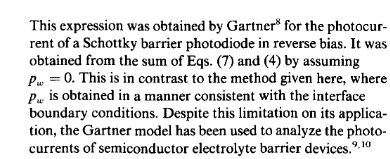

## Generation current

In [7]:
# Use the classes defined above as arguments to the functions

def W(V, Material, Surface):
    """Width of space charge layer"""
    if (Surface.ϕb0 - V) > 0:
        W = ((2*(Surface.ϕb0 - V)*Material.ϵ*ϵ0)/(q*Material.ND))**0.5
    else:
        W = 0
    return W

def p0(Material):
    """Hole concentration in the bulk"""
    return Material.ni**2/Material.ND

def J_0(Material):
        """Saturation current density
           depends on diffusion length L and lifetime τ 
           but not on voltage"""
        return (q*p0(Material)*Material.L)/Material.τ 
    
def J_generation(V, Material, Illumination):
    """Involves light, is the generation current"""
    term1 = J_0(Material)
    term2 = np.exp(-Illumination.α*W(V, Material, Surface))
    term3 = 1+ Illumination.α*Material.L
    return  term1 + Illumination.I0*(1 - term2/term3)

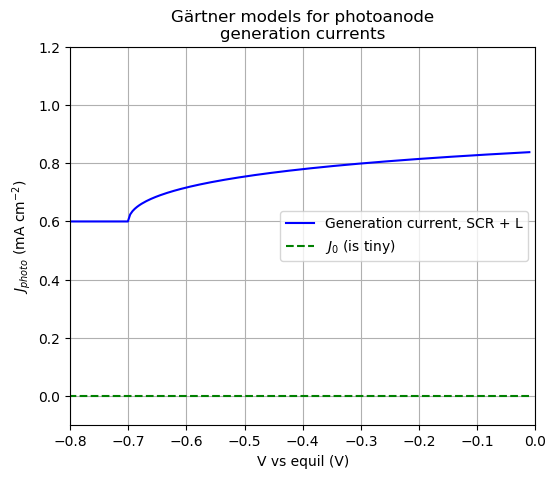

In [8]:
# Plot generation current and J0

V_plot=np.linspace(0.01,0.8,200)*volt

# Using np.array so that can do mathematical operations on them later
temp1 =  np.array([J_0(GaAs) for V in V_plot])
temp2 =  np.array([J_generation(V, GaAs, base_illumination) for V in V_plot])

plt.figure(figsize=(6,5), dpi=100)
plt.title('Gärtner models for photoanode\ngeneration currents')
plt.plot(-V_plot/volt, temp2/(mA*cm**-2), 'b', label = "Generation current, SCR + L") 

plt.plot(-V_plot/volt, temp1/(mA*cm**-2), 'g--', label = "$J_0$ (is tiny)") 

plt.legend(loc='center right')
plt.xlabel("V vs equil (V)")
plt.xlim(-0.8,0.0)
plt.ylim(-0.1,1.2)
plt.ylabel("$J_{photo}$ (mA cm$^{-2}$)")
plt.grid()
plt.show()


## Electron and hole currents
now consider the electron and hole currents at the surface

$$ J_n = -I_{n0}(n_s/n_{s0} -1) $$

$$ J_p = I_{p0}(p_s/p_{s0} -1) $$

At equilibrium, both electron and hole currents are zero. This corresponds to the $E_0$ for the redox reaction because it is assumed that voltage drop across Helmholtz layer does not change with illumination or voltage applied to the semiconductor. 
Excess electrons will produce a negative current (cathode)  
Excess holes will produce a positive current (anode).  
Reaction rates with the electrolyte are captured in $I_{n0}$ and $I_{p0}$  
Analysis is similar to that used for surface recombination (except that hole and electron currents are equal and opposite). 

In [9]:
# The rest of the Gartner model
def J_n(V, Material, Surface):
    """Electron current, does not depend on illumination"""
    return -Surface.I0n*(np.exp((q*V)/(kB*T))-1)

def J_p(V,  Material, Surface, Illumination):
    """Depends on everything"""
    numerator = J_generation(V, Material, Illumination) - J_0(Material)*np.exp((q*V)/(kB*T))
    demoninator = 1 + (J_0(Material)*np.exp((q*V)/(kB*T)))/(Surface.I0p)
    return numerator/demoninator

def J_Gartner(V,  Material, Surface, Illumination):
    """Total current in the Gartner model"""
    return J_n(V, Material, Surface) + J_p(V, Material, Surface, Illumination)


# Reichmann model with recombination in SCR

## Recombination equations

In [10]:
# Redo using the classes

def A(V, Surface):
    """Coefficient in equation"""
    return Surface.I0p + J_0(Material)*np.exp((q*V)/(kB*T))

def B(V, Material, Surface, Illumination):
    """Another coefficient"""
    return Surface.I0p + J_generation(V, Material, Illumination)

def K_eqn11(V, Material, Surface):
    """Another coefficient"""
    first_term = (np.pi*kB*T*Material.ni*W(V, Material, Surface)) /(4*Material.τ*(Surface.ϕb0-V))
    second_term = np.exp((q*V)/(2*kB*T))
    return first_term*second_term

def p_surface_ratio(V, Material, Surface, Illumination):
    """Does not depend on light?"""
    numerator = -K_eqn11(V, Material, Surface) + \
                (K_eqn11(V, Material, Surface)**2 + \
                 4*A(V, Surface)*B(V,Material, Surface, Illumination))**0.5
    demoninator = 2*A(V, Surface)
    return (numerator/demoninator)**2

def J_p_eqn2(V, Material, Surface, Illumination):
    return Surface.I0p * (p_surface_ratio(V, Material, Surface, Illumination) - 1)

def J_total_Reichman(V, Material, Surface, Illumination):
    """J_n is the same as Gartner, J_p is different"""
    return J_n(V, Material, Surface) + J_p_eqn2(V, Material, Surface, Illumination)

def J_recombo_SCR(V, Material, Surface, Illumination):
    """Recombination in SCR"""
    return K_eqn11(V, Material, Surface) * p_surface_ratio(V, Material, Surface, Illumination)**0.5


working

## Analysis of the base case

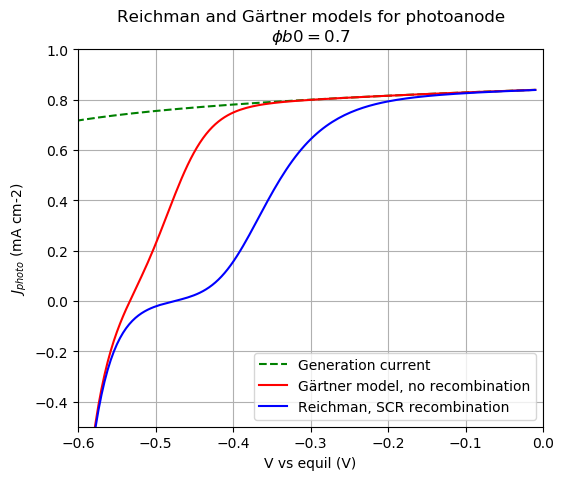

In [11]:
# Working with the new class-based method
temp1 = np.array([J_generation(V, GaAs, base_illumination) for V in V_plot])
temp2 = np.array([J_Gartner(V, *base_case) for V in V_plot])
temp3 = np.array([J_total_Reichman(V, *base_case) for V in V_plot])

plt.figure(figsize=(6,5), dpi=100)

plt.plot(-V_plot/volt, temp1/(mA*cm**-2), 'g--', label = "Generation current") 
plt.plot(-V_plot/volt, temp2/(mA*cm**-2), 'r', label = "Gärtner model, no recombination") 
plt.plot(-V_plot/volt, temp3/(mA*cm**-2), 'b', label = "Reichman, SCR recombination") 

plt.legend(loc='best')
plt.title('Reichman and Gärtner models for photoanode\n$\phi b0=${}'.format(base_surface.ϕb0))
plt.xlabel("V vs equil (V)")
plt.xlim(-0.6,0.0)
plt.ylim(-0.5,1.0)
plt.ylabel("$J_{photo}$ (mA cm-2)")
plt.grid()
plt.show()

Electron current increases as voltage goes cathodic. It exceeds the hole current before flat band is reached. 

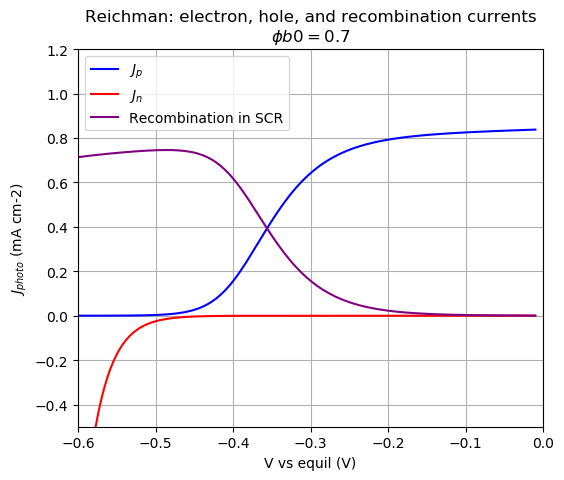

In [12]:
plt.figure(figsize=(6,5), dpi=100)
plt.plot(-V_plot/volt, np.array([J_p_eqn2(V, *base_case) for V in V_plot])/(mA*cm**-2), 
         'b', label = "$J_p$") 
plt.plot(-V_plot/volt, np.array([J_n(V, GaAs, base_surface) for V in V_plot])/(mA*cm**-2), 
         'r', label = "$J_n$") 
plt.plot(-V_plot/volt, np.array([J_recombo_SCR(V, *base_case) for V in V_plot])/(mA*cm**-2), 
         'purple', label = "Recombination in SCR") 

plt.legend(loc='best')
plt.title('Reichman: electron, hole, and recombination currents\n$\phi b0=${}'.format(base_surface.ϕb0))
plt.xlabel("V vs equil (V)")
plt.xlim(-0.6,0.0)
plt.ylim(-0.5,1.2)
plt.ylabel("$J_{photo}$ (mA cm-2)")
plt.grid()
plt.show()

At 0 vs. equil. (e.g. 1.23 V vs RHE for an OER photoanode, bands are bent up as shown in the figure above.  
As a result, there are not many holes at the surface or in the SCR. So actually nearly all of the photogenerated holes get to the surface and drive the oxidation reaction.
As the potential goes negative there is less band bending. 
The recombination current goes up. Eventually, the electron current turns on and becomes equal in magnitude to the hole current. A this point total current is zero: is open circuit voltage or onset potential. 

**Electron and hole populations at the surface**

## Case comparisons

**Hole lifetime and hole transfer rate**

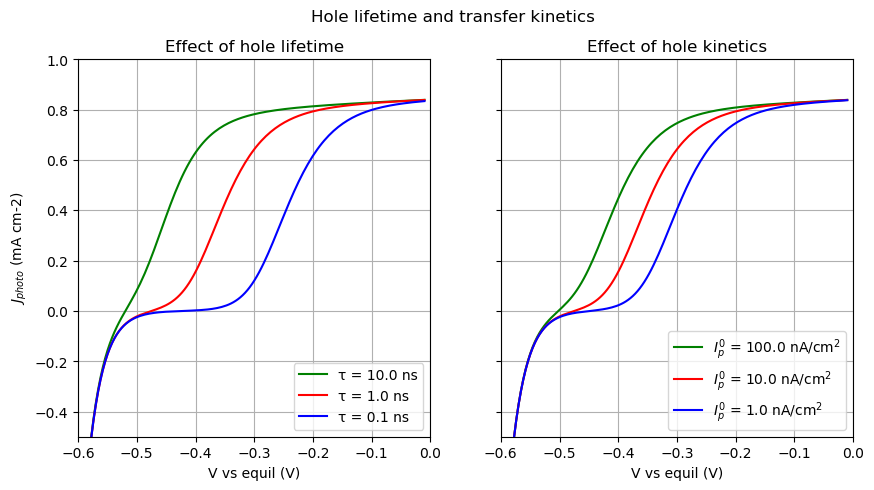

In [13]:
# Hole Lifetime
GaAs_longer_τ = Material()
GaAs_longer_τ.τ = 10*GaAs.τ

GaAs_shorter_τ = Material()
GaAs_shorter_τ.τ = 0.1*GaAs.τ

case1a = (GaAs_longer_τ, base_surface, base_illumination)
case2a = base_case
case3a = (GaAs_shorter_τ, base_surface, base_illumination)

# Working with the new class-based method
temp1a = np.array([J_total_Reichman(V, *case1a) for V in V_plot])
temp2a = np.array([J_total_Reichman(V, *case2a) for V in V_plot])
temp3a = np.array([J_total_Reichman(V, *case3a) for V in V_plot])

# Hole kinetics with solution
# Hole kinetics
faster_holes = Surface()
faster_holes.I0p = 1e1*base_surface.I0p

slower_holes = Surface()
slower_holes.I0p = 1e-1*base_surface.I0p

case1b = (GaAs, faster_holes, base_illumination)
case2b = base_case
case3b = (GaAs, slower_holes, base_illumination)

# Working with the new class-based method
temp1b = np.array([J_total_Reichman(V, *case1b) for V in V_plot])
temp2b = np.array([J_total_Reichman(V, *case2b) for V in V_plot])
temp3b = np.array([J_total_Reichman(V, *case3b) for V in V_plot])


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), dpi=100, sharex=True, sharey=True)
plt.suptitle('Hole lifetime and transfer kinetics')

ax1.set_title('Effect of hole lifetime')
ax1.plot(-V_plot/volt, temp1a/(mA*cm**-2), 'g', label = 'τ = {:.1f} ns'.format(GaAs_longer_τ.τ/ns)) 
ax1.plot(-V_plot/volt, temp2a/(mA*cm**-2), 'r', label = 'τ = {:.1f} ns'.format(GaAs.τ/ns)) 
ax1.plot(-V_plot/volt, temp3a/(mA*cm**-2), 'b', label = 'τ = {:.1f} ns'.format(GaAs_shorter_τ.τ/ns)) 
ax1.set_xlabel("V vs equil (V)")
ax1.set_xlim(-0.6,0.0)
ax1.set_ylim(-0.5,1.0)
ax1.set_ylabel("$J_{photo}$ (mA cm-2)")
ax1.legend(loc='best')
ax1.grid()

ax2.set_title('Effect of hole kinetics')
ax2.plot(-V_plot/volt, temp1b/(mA*cm**-2), 'g', label = '$I^0_p$ = {:.1f} nA/cm$^2$'.format(faster_holes.I0p/(nA*cm**-2))) 
ax2.plot(-V_plot/volt, temp2b/(mA*cm**-2), 'r', label = '$I^0_p$ = {:.1f} nA/cm$^2$'.format(base_surface.I0p/(nA*cm**-2))) 
ax2.plot(-V_plot/volt, temp3b/(mA*cm**-2), 'b', label = '$I^0_p$ = {:.1f} nA/cm$^2$'.format(slower_holes.I0p/(nA*cm**-2))) 

ax2.legend(loc='best')

ax2.set_xlabel("V vs equil (V)")
#plt.xlim(-0.6,0.0)
#plt.ylim(-0.5,1.0)
#plt.ylabel("$J_{photo}$ (mA cm$^{-2}$)")
ax2.grid()

plt.show()

Longer lifetime and faster hole kinetics are desirable. 

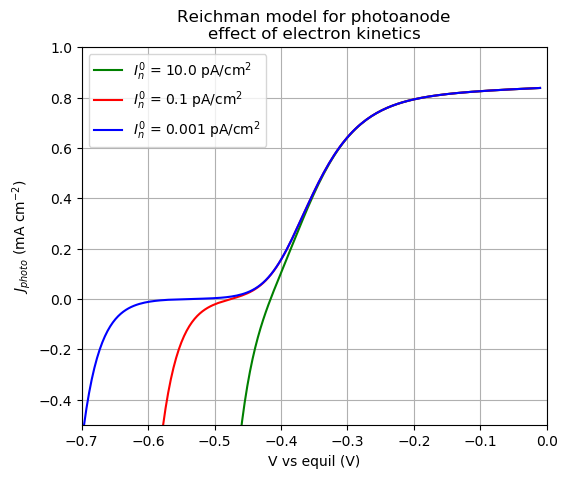

In [14]:
# electron kinetics

faster_electrons = Surface()
faster_electrons.I0n = 1e2*base_surface.I0n

slower_electrons = Surface()
slower_electrons.I0n = 10**-2*base_surface.I0n


case1 = (GaAs, faster_electrons, base_illumination)
case2 = base_case
case3 = (GaAs, slower_electrons, base_illumination)

# Working with the new class-based method
temp1 = np.array([J_total_Reichman(V, *case1) for V in V_plot])
temp2 = np.array([J_total_Reichman(V, *case2) for V in V_plot])
temp3 = np.array([J_total_Reichman(V, *case3) for V in V_plot])

plt.figure(figsize=(6,5), dpi=100)

plt.plot(-V_plot/volt, temp1/(mA*cm**-2), 'g', label = '$I^0_n$ = {:.1f} pA/cm$^2$'.format(faster_electrons.I0n/(pA*cm**-2))) 
plt.plot(-V_plot/volt, temp2/(mA*cm**-2), 'r', label = '$I^0_n$ = {:.1f} pA/cm$^2$'.format(base_surface.I0n/(pA*cm**-2))) 
plt.plot(-V_plot/volt, temp3/(mA*cm**-2), 'b', label = '$I^0_n$ = {:.3f} pA/cm$^2$'.format(slower_electrons.I0n/(pA*cm**-2))) 

plt.legend(loc='best')
plt.title('Reichman model for photoanode\neffect of electron kinetics')
plt.xlabel("V vs equil (V)")
plt.xlim(-0.7,0.0)
plt.ylim(-0.5,1.0)
plt.ylabel("$J_{photo}$ (mA cm$^{-2}$)")
plt.grid()
plt.show()

Slower electron kinetics are beneficial. 

In [15]:
n_s0 = GaAs.ND*np.exp((-q*base_surface.ϕb0)/(kB*T))
p_s0 = GaAs.ni**2/n_s0

print('Bulk electrons {:.3e} cm^-3'.format(GaAs.ND/cm**-3))
print('Bulk holes {:.3e} cm^-3'.format(p0(GaAs)/cm**-3))
print()
print('Surface electrons at equil {:.3e} cm^-3'.format(n_s0/cm**-3))
print('Surface holes at equil {:.3e} cm^-3'.format(p_s0/cm**-3))
print()
print('Surface holes in light, V = 0:  {:.3e} cm^-3'.format((p_s0*p_surface_ratio(0,*base_case) )/cm**-3))

Bulk electrons 1.000e+16 cm^-3
Bulk holes 1.000e-02 cm^-3

Surface electrons at equil 1.740e+04 cm^-3
Surface holes at equil 5.748e+09 cm^-3

Surface holes in light, V = 0:  4.824e+14 cm^-3


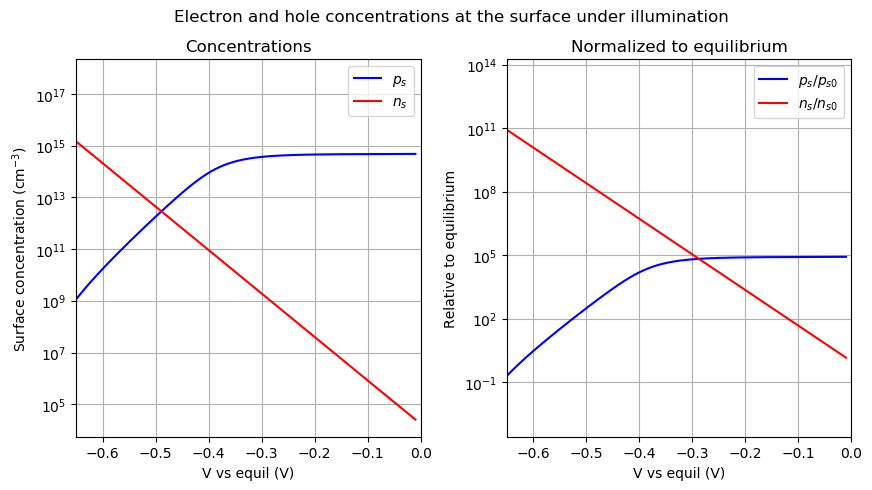

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), dpi=100, sharex=True)
plt.suptitle('Electron and hole concentrations at the surface under illumination')

ax1.set_title('Concentrations')
ax1.semilogy(-V_plot/volt, [p_surface_ratio(V, *base_case)*p_s0/cm**-3 for V in V_plot],
         'b', label = "$p_s$") 

ax1.semilogy(-V_plot/volt, [np.exp((q*V)/(kB*T))*n_s0/cm**-3 for V in V_plot],
         'r', label = "$n_s$") 
ax1.legend(loc='best')
ax1.set_xlabel("V vs equil (V)")
ax1.set_xlim(-0.65,0.0)
#plt.ylim(-0.5,1)
ax1.set_ylabel("Surface concentration (cm$^{-3}$)")
ax1.grid()

ax2.set_title('Normalized to equilibrium')
ax2.semilogy(-V_plot/volt, [p_surface_ratio(V, *base_case) for V in V_plot],
         'b', label = "$p_s/p_{s0}$") 

ax2.semilogy(-V_plot/volt, [np.exp((q*V)/(kB*T)) for V in V_plot],
         'r', label = "$n_s/n_{s0}$") 
ax2.legend(loc='best')
ax2.set_xlabel("V vs equil (V)")
ax2.set_xlim(-0.65,0.0)
#plt.ylim(-0.5,1)
ax2.set_ylabel("Relative to equilibrium")
ax2.grid()

plt.subplots_adjust(wspace = 0.25)
plt.show()

holes decrease when electrons show up to recombine with them. 

# Comparison to AFORS-Het solar cell simulator

It is interesting to compare the results of the Reichman model to that of solar cell simulators.  
For this purpose I used AFORS-HET but other programs like PC-1D could be used as well.  

Description of [AFORS-HET 1D solar cell simulation code](https://www.helmholtz-berlin.de/forschung/oe/ee/si-pv/projekte/asicsi/afors-het/index_en.html):  
> Rolf Stangl, Caspar Leendertz and Jan Haschke, Numerical Simulation of Solar Cells
and Solar Cell Characterization Methods: the Open-Source on Demand Program AFORS-HET in [Solar Energy
edited by Radu Rugescu, InTech, **2010**](https://www.researchgate.net/profile/Caspar_Leendertz/publication/221907404_Numerical_Simulation_of_Solar_Cells_and_Solar_Cell_Characterization_Methods_the_Open-Source_on_Demand_Program_AFORS-HET/links/00b49517e16bd70305000000/Numerical-Simulation-of-Solar-Cells-and-Solar-Cell-Characterization-Methods-the-Open-Source-on-Demand-Program-AFORS-HET.pdf). 

Simulation solvers for solar cells solve the Poisson equation, shown here in 1D and in steady state:

$$\frac{\epsilon \, \epsilon_0}{q} \frac{\partial^2 \phi(x)}{\partial x^2} = p(x) + n(x) + N_D(x) - N_A(x) + \sum_{trap} \rho_{trap}(x) \tag{1}$$

and also electron and hole drift-diffusion equations:

$$-\frac{1}{q} \frac{\partial j_n(x)}{\partial x} = G_n(x) -R_n(x) \tag{2}$$

$$+\frac{1}{q} \frac{\partial j_p(x)}{\partial x} = G_p(x) -R_p(x) \tag{3}$$

The electron and hole currents are related to gradients in the corresponding quasi-Fermi energies:

$$j_n(x) = q \, \mu_n \frac{\partial E_{Fn}}{\partial x} \tag{4}$$


$$j_p(x) = q \, \mu_p \frac{\partial E_{Fp}}{\partial x} \tag{5}$$

Substituting (4) and (5) into (2) and (3), one can see that solving for the potential and quasi-Fermi levels involves 3 coupled 2nd order differential equations. A self-consistent approach must be used, as the carrier concentrations in (1) depend on the potential. 

AFORS-HET has 4 different boundary condition setttings:  
1. flat band metal/semiconductor   
2. Schottky metal/semiconductor  
3. Insulator/semiconductor  
4. metal/insulator/semiconductor 

Setting (2) differs only from setting (1) in that an inital band bending due to the Schottky barrier can be specified.  For both these cases, the currents at the front and back contacts are determined by the law of mass action:

$$j^{front}_n = q \, S^{front}_n \, \left[ n(x^{front}) - n^{EQ}(x^{front}) \right] \tag{6}$$  

$$j^{back}_n = -q \, S^{back}_n \, \left[ n(x^{back}) - n^{EQ}(x^{back}) \right] \tag{7}$$

$$j^{front}_p = -q \, S^{front}_p \, \left[ p(x^{front}) - p^{EQ}(x^{front}) \right] \tag{8}$$

$$j^{back}_p = q \, S^{back}_p \, \left[ p(x^{back}) - p^{EQ}(x^{back}) \right] \tag{9}$$

These map onto the following re-expressions of Reichman's electron and hole currents at the semiconductor-electrolyte interface: 

$$J_n = -\frac{I^0_n} {n_{s0}} \, (n_s-n_{s0})$$

$$J_p = +\frac {I^0_p}{ p_{s0}} \, (p_s-p_{s0})$$

allowing us to connect to AFORS-HET and other PV solvers which use SRV as a boundary condition:

$$S_n = \frac{I^0_n} {n_{s0}} $$

$$ S_p = \frac {I^0_p}{ p_{s0}}$$

where it is easy to get the equilibrium surface concentrations from the bulk values and the flat band potential. 

$$n_{s0} = N_D \exp(-\phi_{b0}/k T)$$

$$p_{s0} = p_0 \exp(+\phi_{b0}/k T)$$

In [17]:
SRV_n = ((base_surface.I0n)/(q*GaAs.ND*np.exp((-q*base_surface.ϕb0)/(kB*T))))
SRV_p = ((base_surface.I0p)/(q*p0(GaAs)*np.exp((+q*base_surface.ϕb0)/(kB*T))))

print('Electron SRV for Reichman base case {:.2f} cm/s'.format(SRV_n/(cm*sec**-1)))
print('Hole SRV for Reichman base case {:.2f} cm/s'.format(SRV_p/(cm*sec**-1)))

Electron SRV for Reichman base case 35.87 cm/s
Hole SRV for Reichman base case 10.86 cm/s


**Illumination and absorption**

To simulate the Reichman base case in AFORS-HET, the built-in GaAs material was used with some modifications. 

Looking through the AFORS-HET database for the optical constants of GaAs, we see that at 680 nm, $\hat{n} = 3.9 + 0.16i$.   
As shown below this matches nicely the value used by Reichman. 

Thus I used 680 nm light to approximate the $k$ corresponding to the $\alpha$. 

In [18]:
print('AFORS-HET at 680 nm: α = {:.2e} cm^-1'.format((4*np.pi*np.imag(3.9 + 0.16j)/(680*nm))/(cm**-1)))
print('Reichman base case:  α = {:.2e} cm^-1'.format((base_illumination.α)/(cm**-1)))

AFORS-HET at 680 nm: α = 2.96e+04 cm^-1
Reichman base case:  α = 3.00e+04 cm^-1


AFORS-HET uses mW cm<sup>-2</sup>

I have a note that I used 6(15) somehow. 

In [19]:
watt = meter**2*kg**2*sec**-1
mW = 1e-3*watt
c_light = 299792458*meter*sec**-1

temp = (1*mW*cm**-2)*((2*np.pi*hbar*c_light)/(680*nm))**-1

print('1 mW cm^-2 at 680 nm: {:.3e} photons/cm2'.format(temp/cm**-2))

1 mW cm^-2 at 680 nm: 3.423e+15 photons/cm2


**Intrinsic carrier concentration**

NV and NC were adjusted to produce $n_i \approx 1 \times 10^7$ cm$^{-3}$ 

Basically, this involves increasing $N_C$ such that $N_C = N_V = 1 \times 10^{19}$ cm$^{-3}$

In [20]:
def ni_calculator(NV, NC):
    T = 300*kelvin
    Eg = 1.424*eV    # value in AFORS-HET
    term1 = (NV*NC)**0.5
    term2 = np.exp(-Eg/(2*kB*T))
    return term1*term2

print('ni for real GaAs: {:.3e} cm^-3'.format(ni_calculator(0.9e19*cm**-3, 4.7e17*cm**-3)/cm**-3))
print('ni for base case GaAs: {:.3e} cm^-3'.format(ni_calculator(1e19*cm**-3, 1e19*cm**-3)/cm**-3))

ni for real GaAs: 2.250e+06 cm^-3
ni for base case GaAs: 1.094e+07 cm^-3


**Hole mobilty**

This needs to be selected s.t. the values of $\tau$ and $L_p$ are consistent. 

$$L_p = (D \tau)^{1/2} = \left(\frac{\mu_p k_B T}{q} \tau\right)^{1/2}$$

Setting $\mu_p$ = 100 cm<sup>2</sup> V<sup>-1</sup> s<sup>-1</sup> accomplishes this as shown below.  

In [21]:
def Lp_calculator(μ_p):
    D = μ_p*kB*T/q
    return (D*GaAs.τ)**0.5

print('{:.3e}'.format(Lp_calculator(100*cm**2)/cm))
print('{:.3e}'.format(GaAs.L/cm))

5.084e-05
5.000e-05


Three simulations were run with different values for $S_p$ (1, 10, 100 cm/s) corresponding to different values of $I^0_p$. 

A value of 10 corresponds to the base case. 

In [23]:
df1 = pd.read_csv('AFORS n-GaAsi Reichman slower case.iv', sep='\t')
df2 = pd.read_csv('AFORS n-GaAsi Reichman base case.iv', sep='\t')
df3 = pd.read_csv('AFORS n-GaAsi Reichman faster case.iv', sep='\t')
df2.columns

Index(['v [V] ', 'j [A/cm^2] ', 'p [W/cm^2] '], dtype='object')

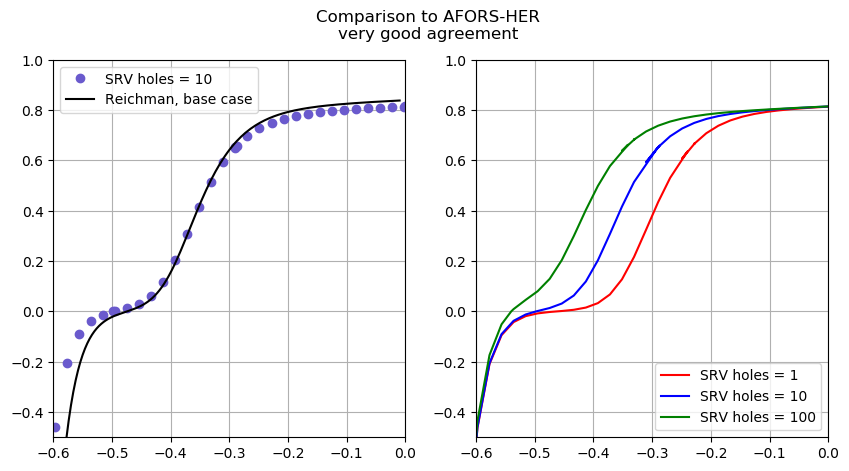

In [35]:
temp3 = np.array([J_total_Reichman(V, *base_case) for V in V_plot])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), dpi=100, sharex=True)

plt.suptitle('Comparison to AFORS-HER\nvery good agreement')
ax1.plot(df2.values[:,0], -df2.values[:,1]/mA, 'slateblue', marker='o', linestyle='none',
         label='SRV holes = 10')
ax1.plot(-V_plot/volt, temp3/(mA*cm**-2), 'k', label = "Reichman, base case") 
ax1.set_xlim(-0.6,0.0)
ax1.set_ylim(-0.5,1)
ax1.legend()
ax1.grid()

ax2.plot(df1.values[:,0], -df1.values[:,1]/mA,'r-', label='SRV holes = 1')
ax2.plot(df2.values[:,0], -df2.values[:,1]/mA,'b-', label='SRV holes = 10')
ax2.plot(df3.values[:,0], -df3.values[:,1]/mA, 'g-', label='SRV holes = 100')
ax2.set_ylim(-0.5,1)
ax2.legend()
ax2.grid()

plt.show()

Could reduce the SRV of the electrons to improve the fit, potentially. 